# Impact of the Thomas Fire on Santa Barbar County Air Quality
Author: Heather Childers
Github Repo: https://github.com/hmchilders/ThomasFire_AQI

## About this Notebook:
The purpose of this exercise is to explore the impact of the 2017 Thomas fire on Santa Barbara County air quality and land cover. We'll analyze the impact on air quality by plotting the daily and 5-day rolling average values of the air quality index for 2017 and 2018 to compare the AQI during the Thomas fire to the usual AQI for the area. We'll explore the land cover change by using a false color image of Santa Barbara County and comparing it with the fire scar from the Thomas Fire.

Some highlights of this analysis include:
- Fetching data from an online repository
- Data wrangling
- Time Series analysis
- Creating line plots with a legend
- Creating a false color image
- Visulaizing raster data

## About the data:
We'll be using the following Datasets for this analysis:

1. Air Quality Index (AQI) data from the US Environmental Protection Agency to visualize the impact on the AQI of the 2017 Thomas Fire in Santa Barbara County.
The data can be accesses here: “AirData Website File Download Page.” EPA, Environmental Protection Agency, aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed 28 Nov. 2023. 

2. A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.
The data can be accessed in the data folder of this repository. More info can be found here: “Microsoft Planetary Computer.” Planetary Computer, planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed 28 Nov. 2023.  

3. A shapefile of fire perimeters in California during 2017
The data can be accessed here: “California Fire Perimeters (All).” California State Geoportal, California Department of Forestry and Fire Protection, gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed 28 Nov. 2023. 

## Import the Necessary Libraries

In [1]:
#Import the libraries and functions needed for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from shapely import Point
from shapely.geometry import box
from rasterio.features import rasterize 

## Load in the Data

In [3]:
# read in the 2017 AQI data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')

# read in the 2018 AQI data
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

# Import the LandSat8 data
landsat = rioxr.open_rasterio(os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc'))

# Import the CalFire data
calfire = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp')

## Prepare the AQI Data

In [5]:
# Concatenate 2 dataframes
aqi = pd.concat([aqi_17,aqi_18])

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

# as a "one liner" you could achieve this column name cleaning like this:
# aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# Use df.loc to filter to the Santa Barbara rows and columns
aqi_sb = aqi.loc[aqi.county_name == 'Santa Barbara',['date', 'aqi', 'category','defining_parameter', 'defining_site', 'number_of_sites_reporting']]

types = aqi_sb.dtypes

# Overwrite the current date columns and set the dates to a datetime object
aqi_sb.date = pd.to_datetime(aqi_sb.date)

# Use set_index to reset the index 
aqi_sb = aqi_sb.set_index('date')

# access the index
aqi_index = aqi_sb.index

# add the 5 Day Average column
aqi_sb.aqi.rolling('5D').mean()
aqi_sb = aqi_sb.assign(Five_day_average = aqi_sb.aqi.rolling('5D').mean())

## Plot the AQI Data

<AxesSubplot:title={'center':'Santa Barbara County Air Quality Index from 2017-2018'}, xlabel='Year', ylabel='Air Quality Index'>

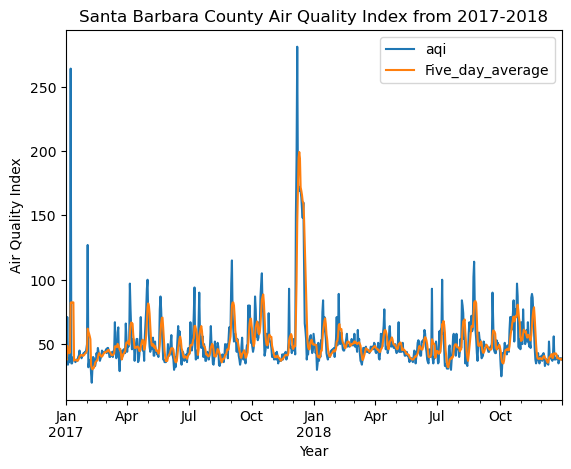

In [9]:
# plot the data
aqi_sb.plot(use_index = True, 
        y= ['aqi', 'Five_day_average'],
        title='Santa Barbara County Air Quality Index from 2017-2018',
        xlabel='Year',
        ylabel='Air Quality Index'
        )

## Prepare the Land Cover Data

In [10]:
#----UPDATE THE DATA----
#Select only the thomas fire from the calfire data
calfire = calfire[calfire['FIRE_NAME'] == 'THOMAS']
# Use the squeeze method to remove dimensions with length 1
landsat = landsat.squeeze()
#Remove coordinates associated with that dimension
landsat = landsat.drop('band')
# Select the false color bands: SWIR, NIR, and Red. Then make it an array
landsat_false = landsat[ ['swir22','nir08','red'] ].to_array()
# Reproject the calfire data to the landsat CRS
calfire = calfire.to_crs(landsat.rio.crs)

## Plot the Land Cover Data

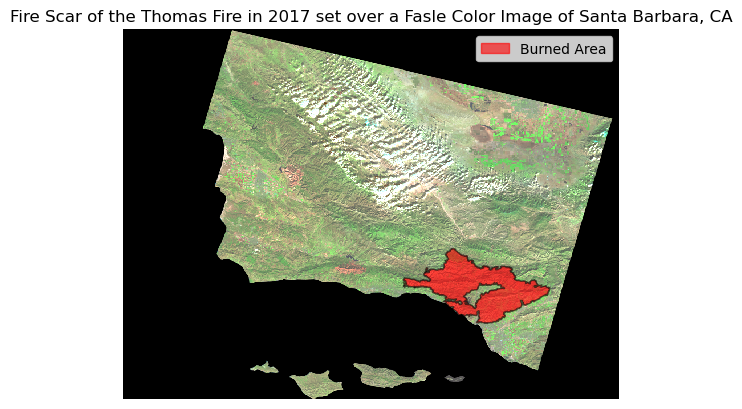

In [11]:
# Create the Figure and Axis
fig, ax = plt.subplots()

#Turn the Axes off
ax.axis('off')

#Plot the Datasets
calfire.plot(ax=ax, color='red', alpha = 0.6, edgecolor='black')
landsat_false.plot.imshow(ax = ax, robust = True)

#Add a figure title
ax.set_title('Fire Scar of the Thomas Fire in 2017 set over a Fasle Color Image of Santa Barbara, CA')

#Add a figure legend
fire_scar = mpatches.Patch(color='red', alpha = 0.6, label='Burned Area')
ax.legend(handles=[fire_scar])

#Show the Plot
plt.show()